<span style='font-family:serif'> <font size="6.7"> <span style='color:#0066cc'>**Volume transport**


<span style='font-family:serif'> <font size="4.5"> Here I inspect that the way OceanSpy computes mooring_array volume transport is consistent whether I used mooring array with cutout or not (e.g.  `serial=False` which is the default, or `serial=True` which is the new way to bypass `cutout`)


The goal is to compare that:    
    
<span style='font-family:serif'> <font size="4.5"> 1) Fields after mooring array are continuous (T, U, V, etc).

<span style='font-family:serif'> <font size="4.5"> 2) New grid coordinates `[XU, XV, YU, YV]` are consistent (continuous). This step is important because 

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import gridspec

import oceanspy as ospy
import dask
import copy as _copy

from oceanspy.llc_rearrange import mates, rotate_vars
from oceanspy.compute import mooring_volume_transport


In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
# Directory
ECCO_url = "catalog_ECCO.yaml"
ECCOod = ospy.open_oceandataset.from_catalog("LLC", ECCO_url)
od = ECCOod

Opening LLC.


In [4]:
co_list = [var for var in od._ds.coords if var not in od._ds.dims]
_ds = od._ds.reset_coords()

test = True
pair = []
if test:
    pair=['UVELMASS', 'VVELMASS']

nU = _copy.deepcopy(_ds['CS']).expand_dims({"time":1}).values
nV = -_copy.deepcopy(_ds['SN']).expand_dims({"time":1}).values

Ucoords = {
    'time': _ds.time.values,
    'face': _ds.face.values,
    'Y': _ds.Y.values,
    'Xp1': _ds.Xp1.values,
}

Vcoords = {
    'time': _ds.time.values,
    'face': _ds.face.values,
    'Yp1': _ds.Yp1.values,
    'X': _ds.X.values,
}

_ds['UVELMASS'] = xr.DataArray(nU, coords=Ucoords, dims=['time', 'face', 'Y', 'Xp1'])
_ds['VVELMASS'] = xr.DataArray(nV, coords=Vcoords, dims=['time','face', 'Yp1', 'X'])


_ds = mates(_ds.set_coords(co_list), ['UVELMASS', 'VVELMASS'])

od._ds = _ds

Yind, Xind = xr.broadcast(od._ds["Y"], od._ds["X"])
Yind = Yind.expand_dims({"face": od._ds["face"]})
Xind = Xind.expand_dims({"face": od._ds["face"]})
od._ds["Xind"] = Xind.transpose(*od._ds["XC"].dims)
od._ds["Yind"] = Yind.transpose(*od._ds["YC"].dims)
od._ds = od._ds.set_coords(["Yind", "Xind"])

face_connections = od.face_connections['face']


In [5]:
od._ds

<xarray.Dataset>
Dimensions:    (Xp1: 90, Z: 50, Y: 90, face: 13, time: 1, Yp1: 90, X: 90,
                Zp1: 51, Zu: 50, Zl: 50, time_midp: 0)
Coordinates: (12/43)
  * Xp1        (Xp1) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
    k          (Z) int64 dask.array<chunksize=(50,), meta=np.ndarray>
  * Y          (Y) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * face       (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * Z          (Z) float32 -5.0 -15.0 -25.0 ... -5.039e+03 -5.461e+03 -5.906e+03
    timestep   (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    ...         ...
    maskW      (Z, face, Y, Xp1) bool dask.array<chunksize=(50, 13, 90, 90), meta=np.ndarray>
    maskC      (Z, face, Y, X) bool dask.array<chunksize=(50, 13, 90, 90), meta=np.ndarray>
    maskS      (Z, face, Yp1, X) bool dask.array<chunksize=(50, 13, 90, 90), meta=np.ndarray>
  * time_midp  (time_midp) datetime64[ns] 
    Xind       (face, Y, X) int64 0 1 2 3 4 5 6 7 8 ... 82 83 84 85 86 87 88 89
    Yind       (face, Y, X) int64 0 0 0 0 0 0 0 0 0 ... 89 89 89 89 89 89 89 89
Data variables:
    U          (time, Z, face, Y, Xp1) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    V          (time, Z, face, Yp1, X) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    T          (time, Z, face, Y, X) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    UVELMASS   (time, face, Y, Xp1) float32 0.06158 0.06675 ... -0.9854 -0.9984
    VVELMASS   (time, face, Yp1, X) float32 0.9981 0.9978 ... 0.1705 0.05718
Attributes: (12/22)
    product_time_coverage_start:  1992-01-01T12:00:00
    author:                       Ou Wang and Ian Fenty
    Insitution:                   JPL
    product_version:              ECCO Version 4 Release 3 Extension (ECCOv4r...
    time_units:                   days since 1992-01-01 00:00:00
    Conventions:                  CF-1.6
    ...                           ...
    geospatial_vertical_max:      -5.0
    date_created:                 Tue Aug 27 13:39:23 2019
    time_coverage_start:          1992-01-01T00:00:00
    time_coverage_end:            1992-02-01T00:00:00
    OceanSpy_grid_coords:         {'Y': {'Y': None, 'Yp1': -0.5}, 'X': {'X': ...
    OceanSpy_face_connections:    {'face': {0: {'X': ((12, 'Y', False), (3, '...

# Example arrays

In [6]:
pNA =[{"type":"LineString", "coordinates":[[-48.187388964014374,56.960906991890084],[-51.823752600378015,55.82892030263895],[-52.27829805492346,51.807741963874946],[-51.823752600378015,45.19480715870648],[-58.4146616912871,41.050173711875544],[-63.64193441855983,31.741690106513104],[-45.46011623674165,29.986012735834635],[-21.141934418559835,32.12744005725618],[-14.096479873105277,46.46165714016658],[-14.323752600377993, 57.57533124493861],[-25.914661691287087,60.83059571806558],[-39.55102532765074,60.15902944894782],[-47.96011623674165,56.960906991890084]]}] 
lons_NA, lats_NA = ospy.utils.viewer_to_range(pNA)

extracting LineString


# compute mooring array

In [7]:
args = {
    'Xmoor': lons_NA,
    'Ymoor': lats_NA,
}

In [8]:
%%time
od_moor_serial = od.subsample.mooring_array(**args, serial=True)

Extracting mooring array
CPU times: user 595 ms, sys: 43.3 ms, total: 638 ms
Wall time: 619 ms


In [9]:
%%time
od_moor = od.subsample.mooring_array(**args)

Cutting out the oceandataset.
faces in the cutout [2, 10]
Extracting mooring array.
CPU times: user 621 ms, sys: 13.3 ms, total: 634 ms
Wall time: 635 ms


In [10]:
XC, YC = od_moor._ds['XC'].squeeze().values, od_moor._ds['YC'].squeeze().values
XCs, YCs = od_moor_serial._ds['XC'].squeeze().values, od_moor_serial._ds['YC'].squeeze().values

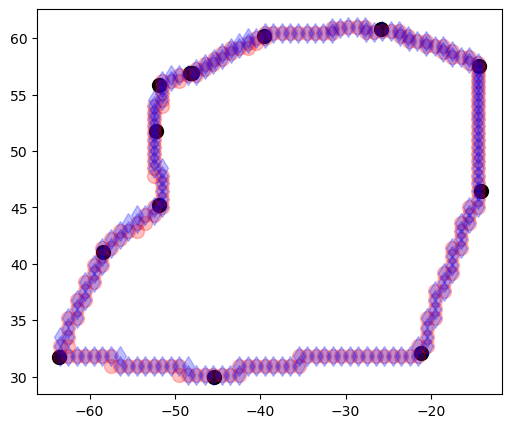

In [11]:
fig = plt.figure(figsize=(6, 5), facecolor='w')
plt.plot(lons_NA, lats_NA,'k', ls='', lw=2, marker='o', markersize=10)
plt.plot(XC, YC, 'r',ls='', marker='o', markersize=10, alpha=0.25)
plt.plot(XCs, YCs, 'b',ls='', marker='d', markersize=10, alpha=0.25)
# plt.xlim(0, 90)
plt.show()

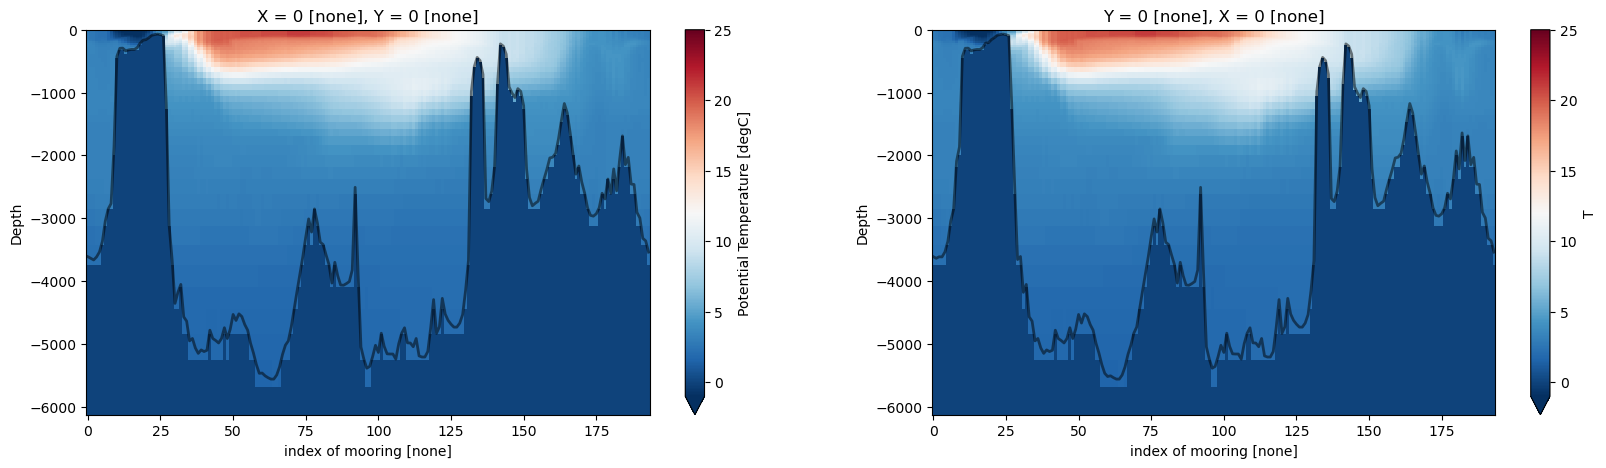

In [12]:
plt.rcParams["figure.figsize"] = [20,5]
fig, axes = plt.subplots(1, 2)
od_moor._ds['T'].squeeze().plot(ax=axes[0], cmap='RdBu_r', vmin=-1, vmax=25)
(1- od_moor._ds['Depth'].squeeze()).plot(ax=axes[0], color='k', lw=2, alpha=0.5)
od_moor_serial._ds['T'].squeeze().plot(ax=axes[1], cmap='RdBu_r', vmin=-1, vmax=25)
(1- od_moor_serial._ds['Depth'].squeeze()).plot(ax=axes[1], color='k', lw=2, alpha=0.5)
plt.show()

# compare velocities

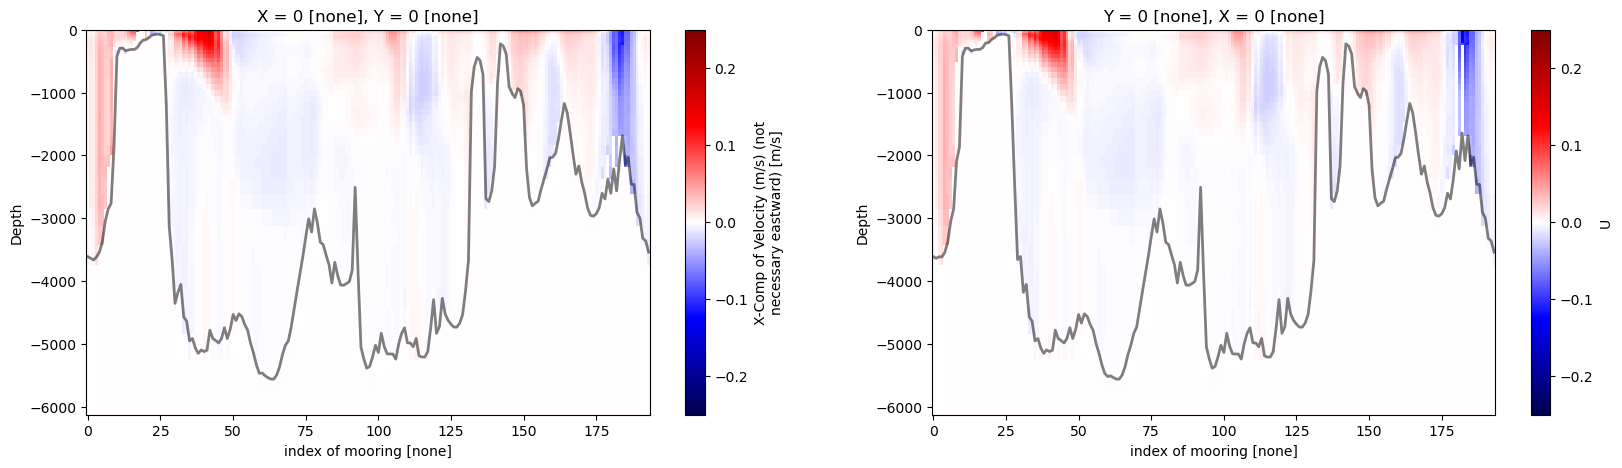

In [13]:
plt.rcParams["figure.figsize"] = [20,5]
fig, axes = plt.subplots(1, 2)
od_moor._ds['U'].isel(Xp1=0).squeeze().plot(ax=axes[0], cmap='seismic', vmin=-0.25, vmax=0.25)
(1- od_moor._ds['Depth'].squeeze()).plot(ax=axes[0], color='k', lw=2, alpha=0.5)
od_moor_serial._ds['U'].isel(Xp1=0).squeeze().plot(ax=axes[1], cmap='seismic', vmin=-0.25, vmax=0.25)
(1- od_moor_serial._ds['Depth'].squeeze()).plot(ax=axes[1], color='k', lw=2, alpha=0.5)
plt.show()

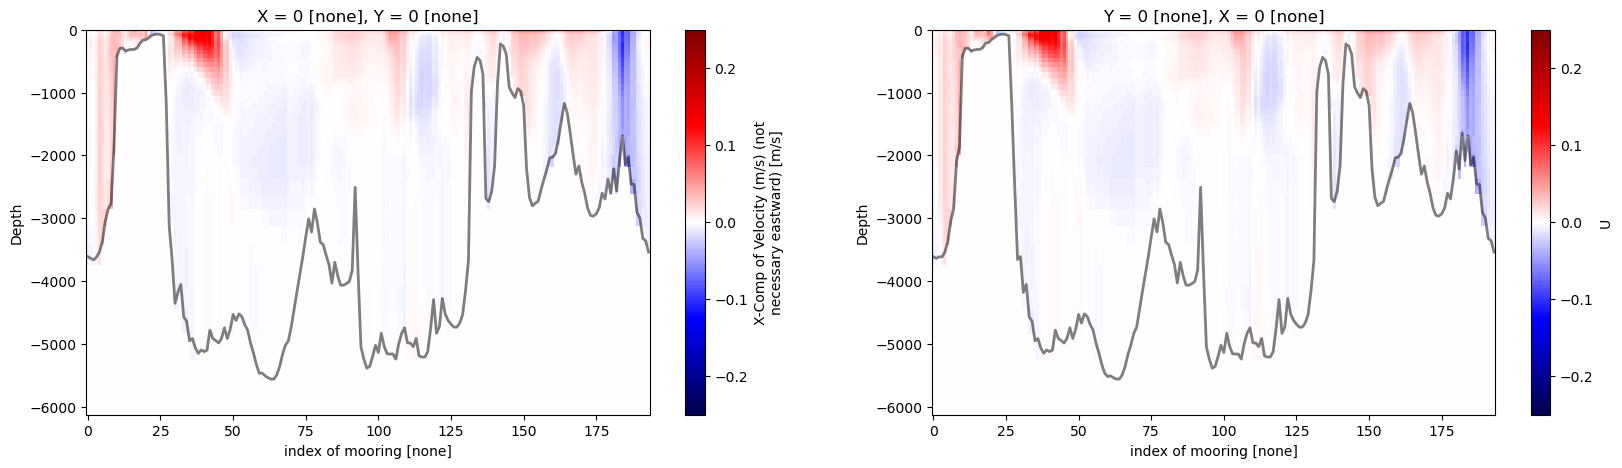

In [14]:
plt.rcParams["figure.figsize"] = [20,5]
fig, axes = plt.subplots(1, 2)
od_moor._ds['U'].isel(Xp1=1).squeeze().plot(ax=axes[0], cmap='seismic', vmin=-0.25, vmax=0.25)
(1- od_moor._ds['Depth'].squeeze()).plot(ax=axes[0], color='k', lw=2, alpha=0.5)
od_moor_serial._ds['U'].isel(Xp1=1).squeeze().plot(ax=axes[1], cmap='seismic', vmin=-0.25, vmax=0.25)
(1- od_moor_serial._ds['Depth'].squeeze()).plot(ax=axes[1], color='k', lw=2, alpha=0.5)
plt.show()

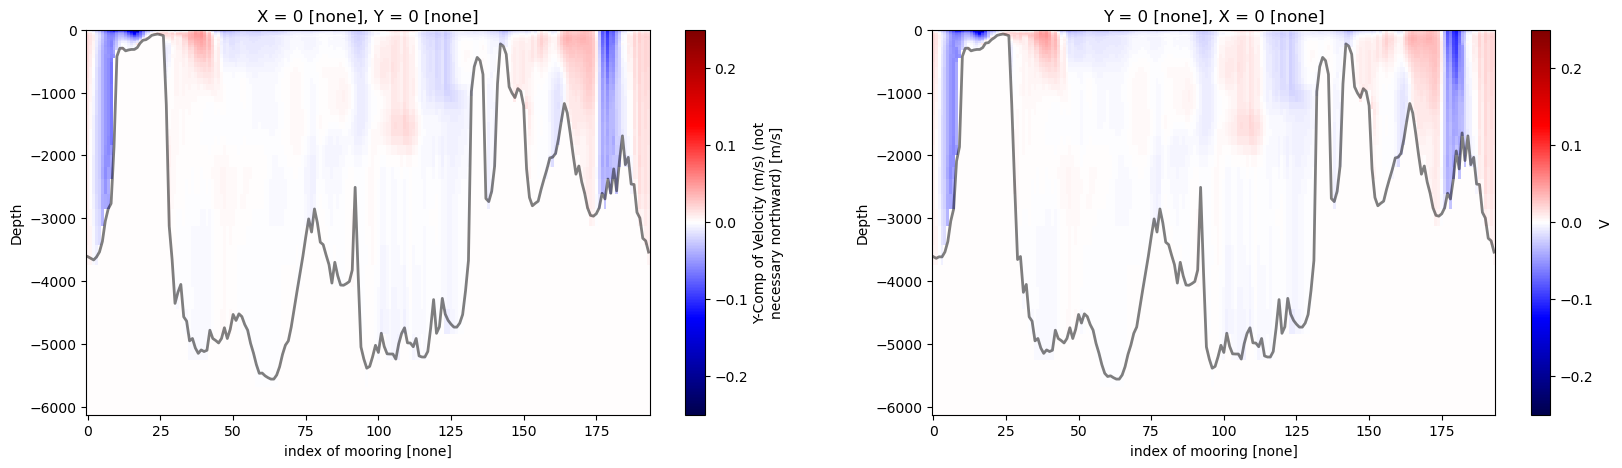

In [15]:
plt.rcParams["figure.figsize"] = [20,5]
fig, axes = plt.subplots(1, 2)
od_moor._ds['V'].isel(Yp1=0).squeeze().plot(ax=axes[0], cmap='seismic', vmin=-0.25, vmax=0.25)
(1- od_moor._ds['Depth'].squeeze()).plot(ax=axes[0], color='k', lw=2, alpha=0.5)
od_moor_serial._ds['V'].isel(Yp1=0).squeeze().plot(ax=axes[1], cmap='seismic', vmin=-0.25, vmax=0.25)
(1- od_moor_serial._ds['Depth'].squeeze()).plot(ax=axes[1], color='k', lw=2, alpha=0.5)
plt.show()

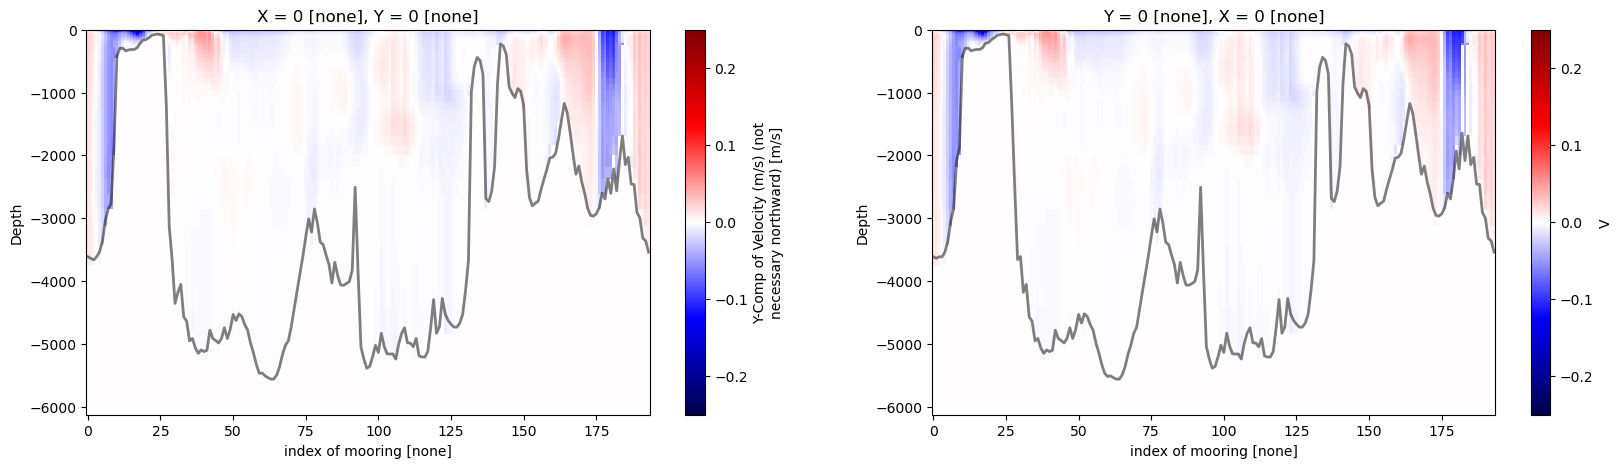

In [16]:
plt.rcParams["figure.figsize"] = [20,5]
fig, axes = plt.subplots(1, 2)
od_moor._ds['V'].isel(Yp1=1).squeeze().plot(ax=axes[0], cmap='seismic', vmin=-0.25, vmax=0.25)
(1- od_moor._ds['Depth'].squeeze()).plot(ax=axes[0], color='k', lw=2, alpha=0.5)
od_moor_serial._ds['V'].isel(Yp1=1).squeeze().plot(ax=axes[1], cmap='seismic', vmin=-0.25, vmax=0.25)
(1- od_moor_serial._ds['Depth'].squeeze()).plot(ax=axes[1], color='k', lw=2, alpha=0.5)
plt.show()

# Newly created coordinates

## with `cutout`

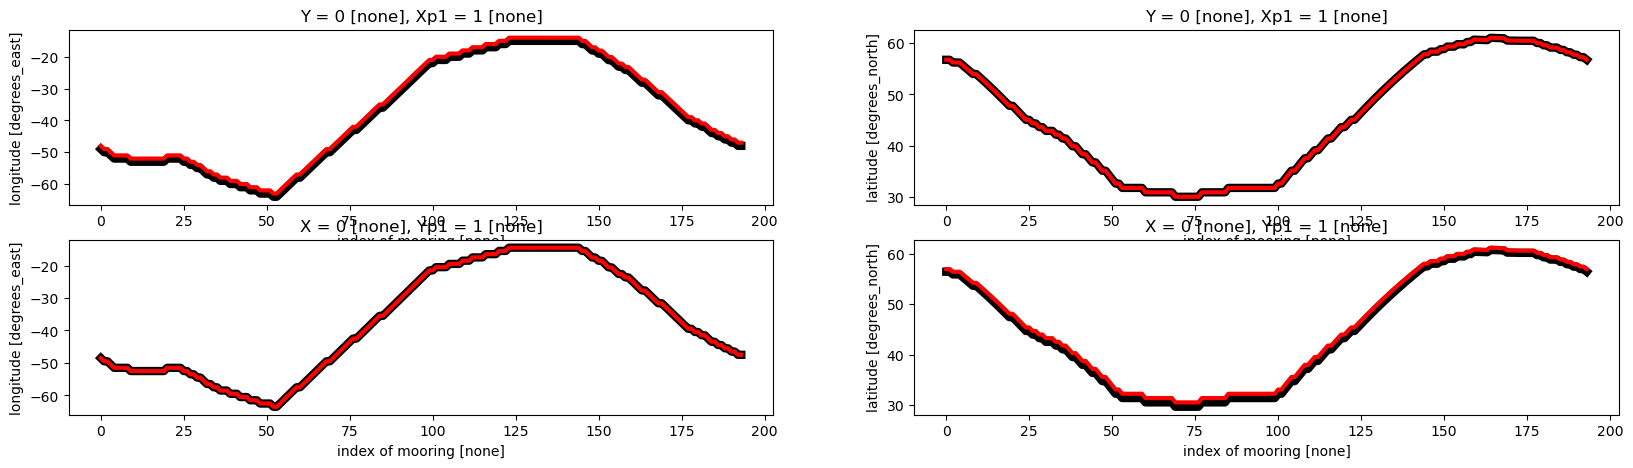

In [17]:

plt.rcParams["figure.figsize"] = [20,5]
fig, axes = plt.subplots(2, 2)

od_moor._ds['XU'].isel(Xp1=0).squeeze().plot(ax=axes[0, 0], color='k', lw=6)
od_moor._ds['XU'].isel(Xp1=1).squeeze().plot(ax=axes[0, 0], color='r', lw=3)

od_moor._ds['YU'].isel(Xp1=0).squeeze().plot(ax=axes[0, 1], color='k', lw=6)
od_moor._ds['YU'].isel(Xp1=1).squeeze().plot(ax=axes[0, 1], color='r', lw=3)

od_moor._ds['XV'].isel(Yp1=0).squeeze().plot(ax=axes[1, 0], color='k', lw=6)
od_moor._ds['XV'].isel(Yp1=1).squeeze().plot(ax=axes[1, 0], color='r', lw=3)

od_moor._ds['YV'].isel(Yp1=0).squeeze().plot(ax=axes[1, 1], color='k', lw=6)
od_moor._ds['YV'].isel(Yp1=1).squeeze().plot(ax=axes[1, 1], color='r', lw=3)


plt.show()

## without `cutout`

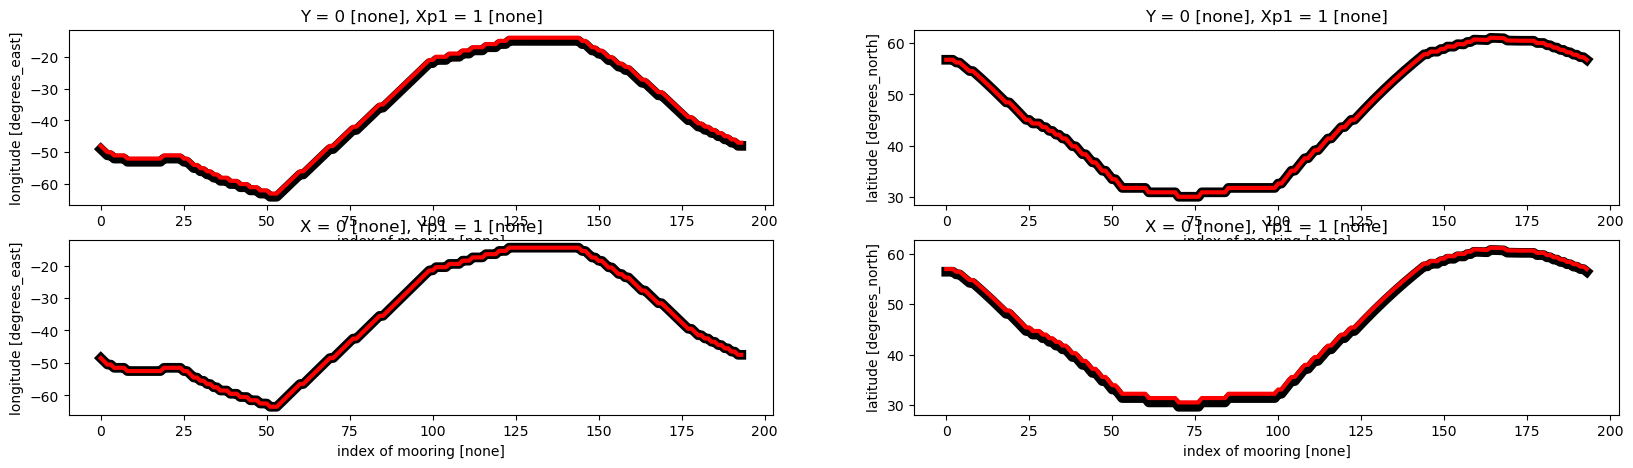

In [18]:
plt.rcParams["figure.figsize"] = [20,5]
fig, axes = plt.subplots(2, 2)

od_moor_serial._ds['XU'].isel(Xp1=0).squeeze().plot(ax=axes[0, 0], color='k', lw=7)
od_moor_serial._ds['XU'].isel(Xp1=1).squeeze().plot(ax=axes[0, 0], color='r', lw=3)

od_moor_serial._ds['YU'].isel(Xp1=0).squeeze().plot(ax=axes[0, 1], color='k', lw=7)
od_moor_serial._ds['YU'].isel(Xp1=1).squeeze().plot(ax=axes[0, 1], color='r', lw=3)

od_moor_serial._ds['XV'].isel(Yp1=0).squeeze().plot(ax=axes[1, 0], color='k', lw=7)
od_moor_serial._ds['XV'].isel(Yp1=1).squeeze().plot(ax=axes[1, 0], color='r', lw=3)

od_moor_serial._ds['YV'].isel(Yp1=0).squeeze().plot(ax=axes[1, 1], color='k', lw=7)
od_moor_serial._ds['YV'].isel(Yp1=1).squeeze().plot(ax=axes[1, 1], color='r', lw=3)


plt.show()

# Volume transport

In [19]:
%%time
ds_out = mooring_volume_transport(od_moor)

Computing horizontal volume transport.
CPU times: user 554 ms, sys: 85.1 ms, total: 639 ms
Wall time: 614 ms


In [20]:
%%time
ds_out_serial = mooring_volume_transport(od_moor_serial)

Computing horizontal volume transport.
CPU times: user 354 ms, sys: 11.4 ms, total: 365 ms
Wall time: 364 ms


# Visual Comparisons of transports

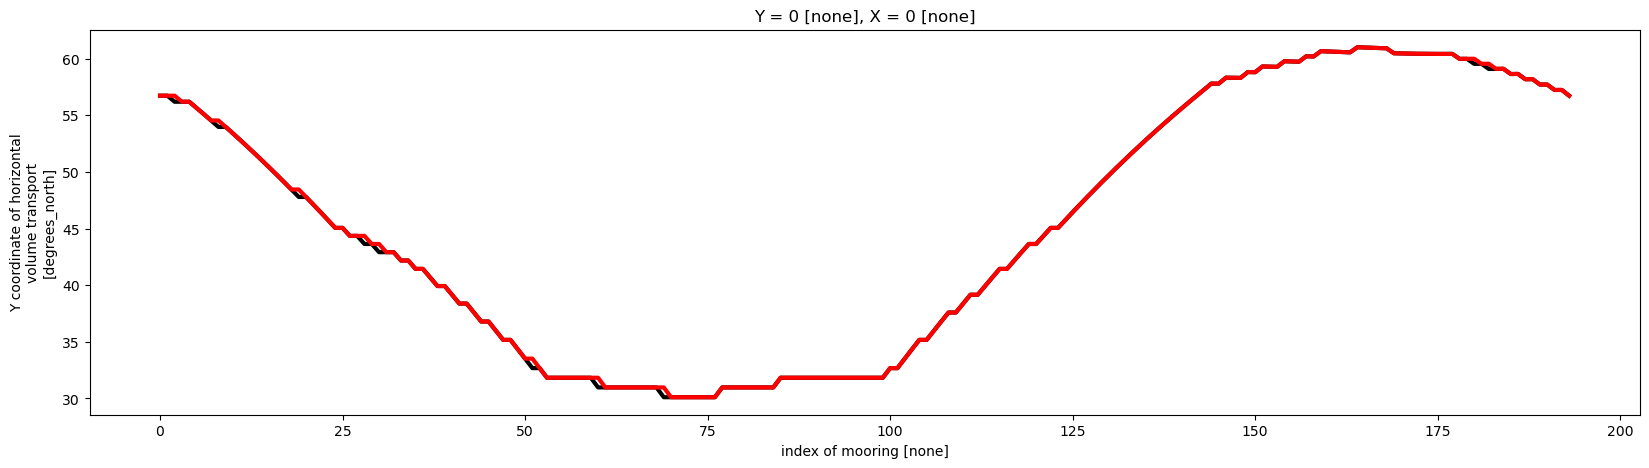

In [21]:
ds_out['Y_transport'].plot(color='k', lw=3)
ds_out_serial['Y_transport'].plot(color='r', lw=3)

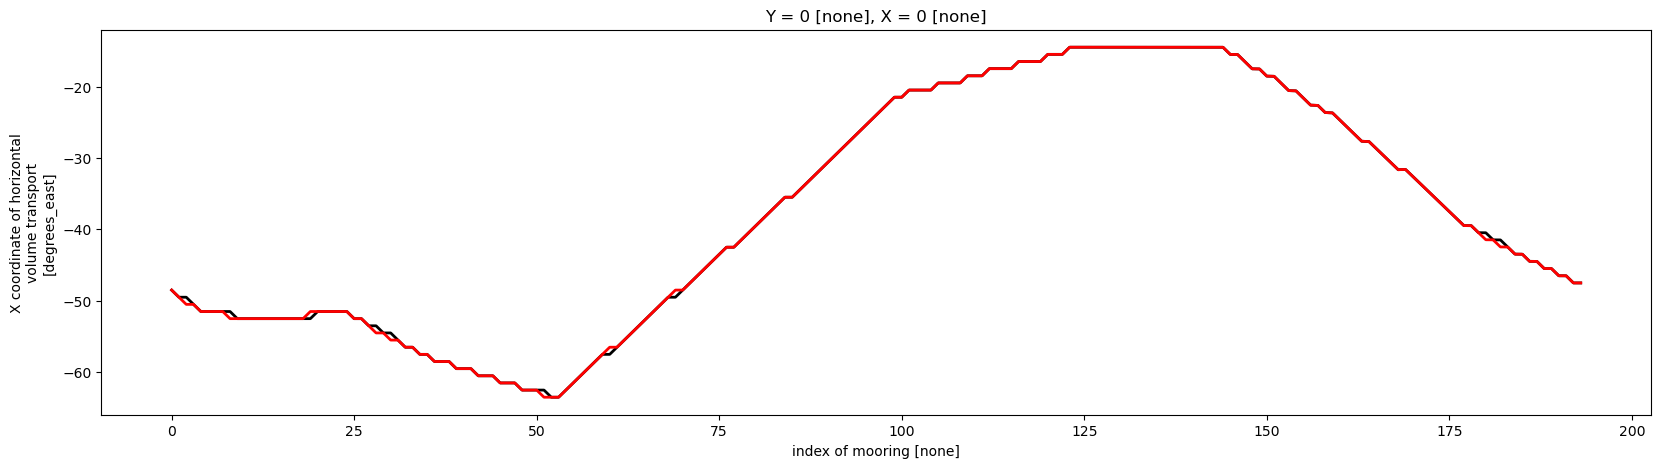

In [22]:
ds_out['X_transport'].plot(color='k', lw=2)
ds_out_serial['X_transport'].plot(color='r', lw=2)

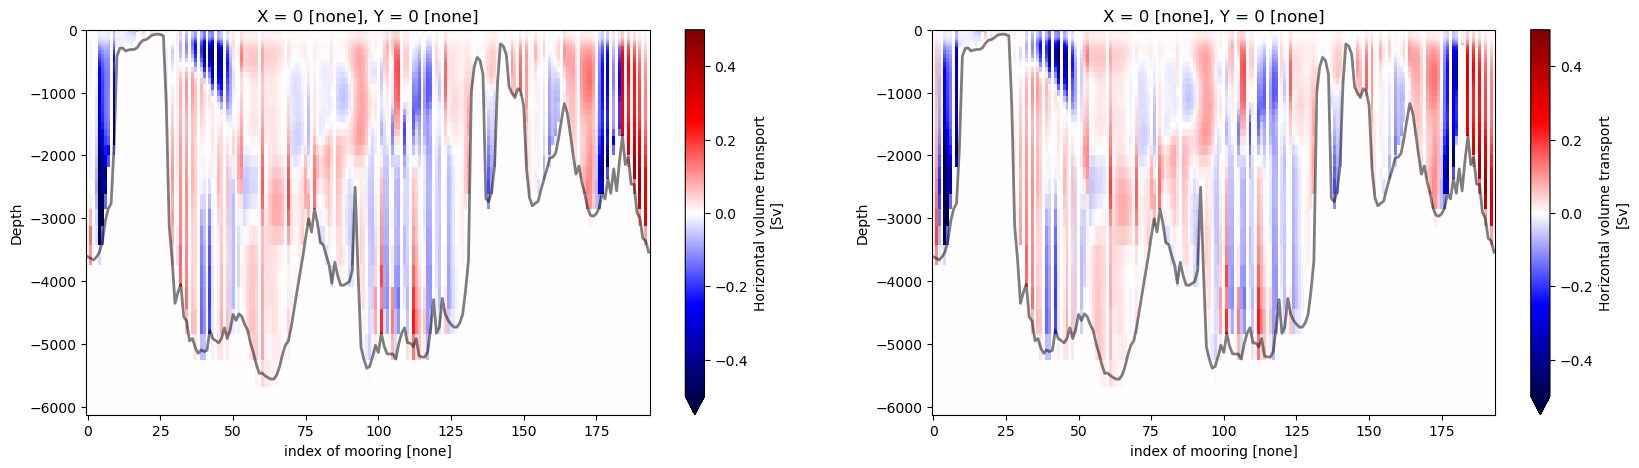

In [23]:
plt.rcParams["figure.figsize"] = [20, 5]
fig, axes = plt.subplots(1, 2)
ds_out['transport'].isel(path=0).squeeze().plot(ax=axes[0], cmap='seismic', vmin=-0.5, vmax=0.5)
(1- od_moor._ds['Depth'].squeeze()).plot(ax=axes[0], color='k', lw=2, alpha=0.5)
ds_out_serial['transport'].isel(path=0).squeeze().plot(cmap='seismic', vmin=-0.5, vmax=0.5)
(1- od_moor._ds['Depth'].squeeze()).plot(color='k', lw=2, alpha=0.5)
plt.show()

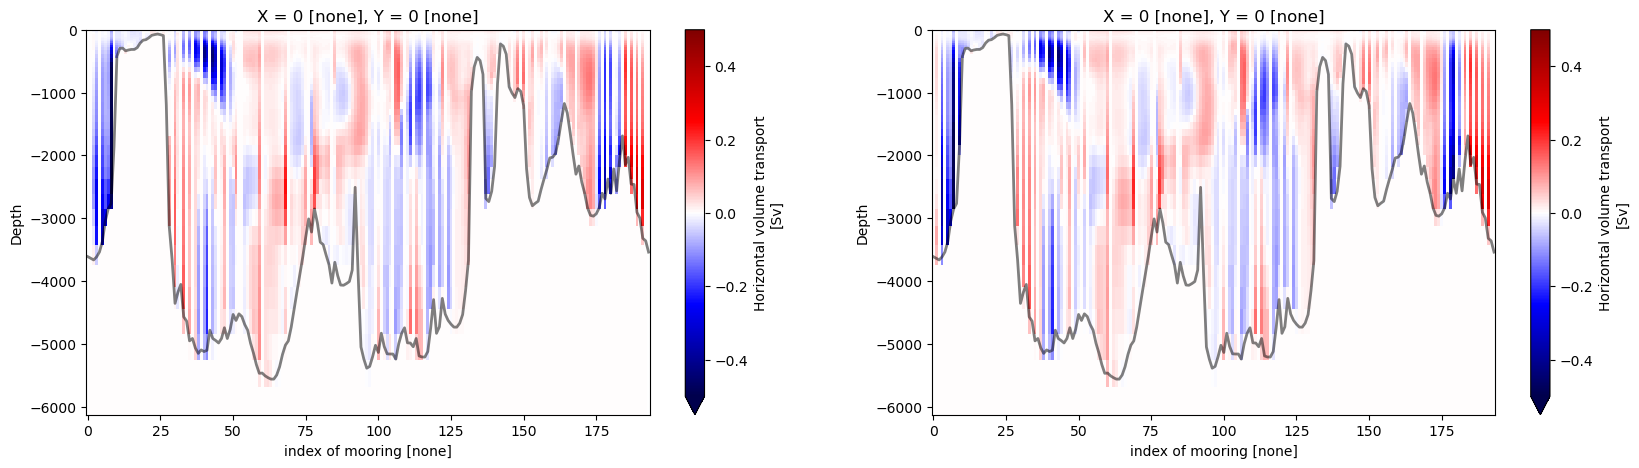

In [24]:
plt.rcParams["figure.figsize"] = [20, 5]
fig, axes = plt.subplots(1, 2)
ds_out['transport'].isel(path=1).squeeze().plot(ax=axes[0], cmap='seismic', vmin=-0.5, vmax=0.5)
(1- od_moor._ds['Depth'].squeeze()).plot(ax=axes[0], color='k', lw=2, alpha=0.5)
ds_out_serial['transport'].isel(path=1).squeeze().plot(cmap='seismic', vmin=-0.5, vmax=0.5)
(1- od_moor._ds['Depth'].squeeze()).plot(color='k', lw=2, alpha=0.5)
plt.show()

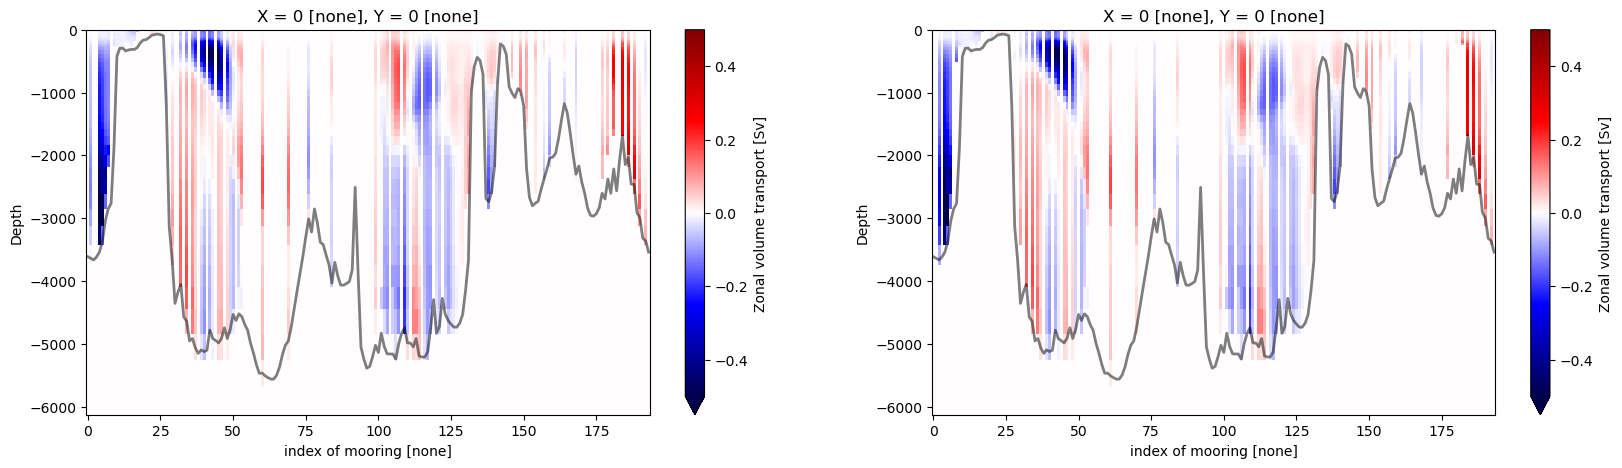

In [25]:
plt.rcParams["figure.figsize"] = [20, 5]
fig, axes = plt.subplots(1, 2)
ds_out['Utransport'].isel(path=0).squeeze().plot(ax=axes[0], cmap='seismic', vmin=-0.5, vmax=0.5)
(1- od_moor._ds['Depth'].squeeze()).plot(ax=axes[0], color='k', lw=2, alpha=0.5)
ds_out_serial['Utransport'].isel(path=0).squeeze().plot(cmap='seismic', vmin=-0.5, vmax=0.5)
(1- od_moor._ds['Depth'].squeeze()).plot(color='k', lw=2, alpha=0.5)
plt.show()

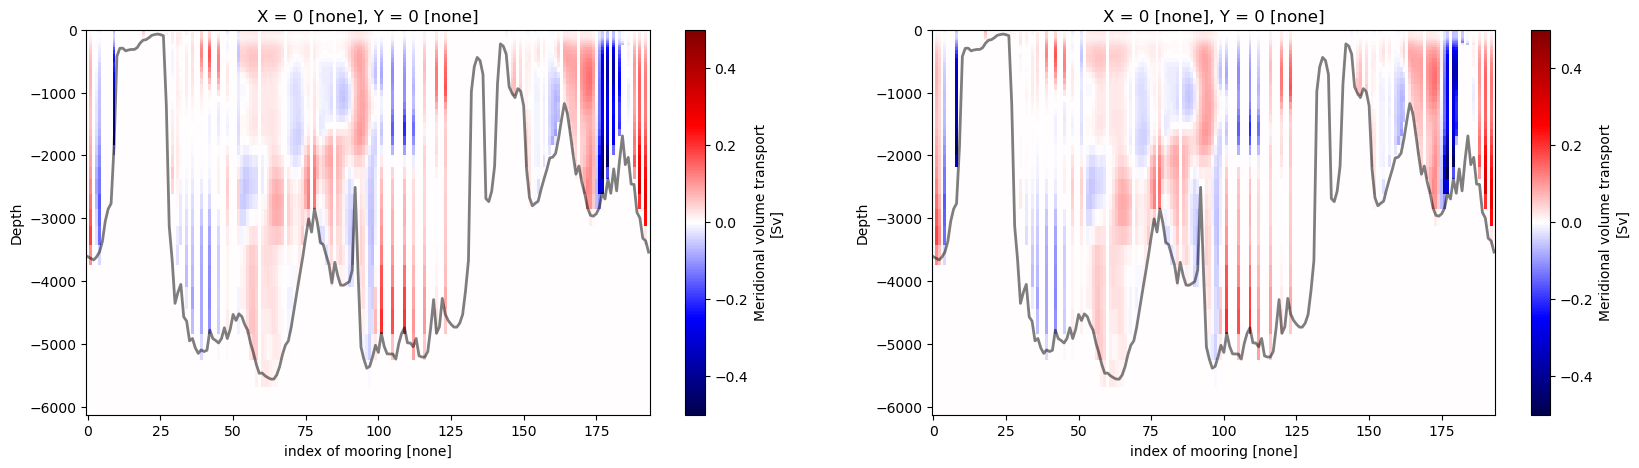

In [26]:
plt.rcParams["figure.figsize"] = [20, 5]
fig, axes = plt.subplots(1, 2)
ds_out['Vtransport'].isel(path=0).squeeze().plot(ax=axes[0], cmap='seismic', vmin=-0.5, vmax=0.5)
(1- od_moor._ds['Depth'].squeeze()).plot(ax=axes[0], color='k', lw=2, alpha=0.5)
ds_out_serial['Vtransport'].isel(path=0).squeeze().plot(cmap='seismic', vmin=-0.5, vmax=0.5)
(1- od_moor._ds['Depth'].squeeze()).plot(color='k', lw=2, alpha=0.5)
plt.show()

In [ ]:
del ds_out, ds_out_serial

# Another Example (Pacific Ocean)

In [27]:
p_pac = [{"type":"Polygon","coordinates":[[[-202.2362892525432,28.108708664548303],[-201.44681556833268,-58.40251957435542],[-93.09155241043796,-57.88166105975242],[-98.02576293675375,29.835293760481562],[-202.2362892525432,28.108708664548303]]]}]

lonsPAC, latsPAC = ospy.utils.viewer_to_range(p_pac)


extracting Polygon


In [28]:
args = {
    'Xmoor': lonsPAC,
    'Ymoor': latsPAC,
}

In [29]:
%%time
od_moor = od.subsample.mooring_array(**args)

Cutting out the oceandataset.
faces in the cutout [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12]
Extracting mooring array.
CPU times: user 2.28 s, sys: 44.1 ms, total: 2.33 s
Wall time: 2.31 s


In [30]:
%%time
od_moor_serial = od.subsample.mooring_array(**args, serial=True)

Extracting mooring array
CPU times: user 1.07 s, sys: 47.3 ms, total: 1.12 s
Wall time: 1.09 s


In [31]:
XC, YC = od_moor._ds['XC'].squeeze().values, od_moor._ds['YC'].squeeze().values
XCs, YCs = od_moor_serial._ds['XC'].squeeze().values, od_moor_serial._ds['YC'].squeeze().values

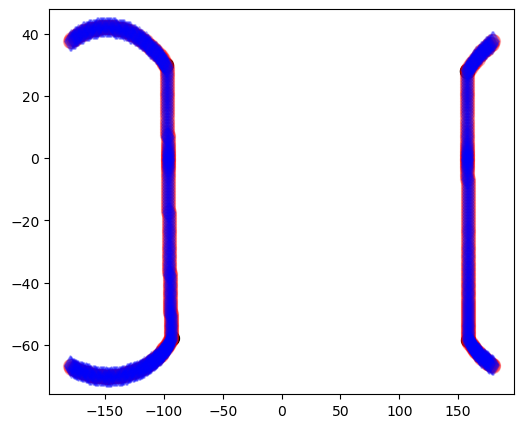

In [32]:
fig = plt.figure(figsize=(6, 5), facecolor='w')
plt.plot(lonsPAC, latsPAC,'k', ls='', lw=2, marker='o', markersize=10)
plt.plot(XC, YC, 'r',ls='', marker='o', markersize=10, alpha=0.25)
plt.plot(XCs, YCs, 'b',ls='', marker='d', markersize=10, alpha=0.25)
# plt.xlim(0, 90)
plt.show()

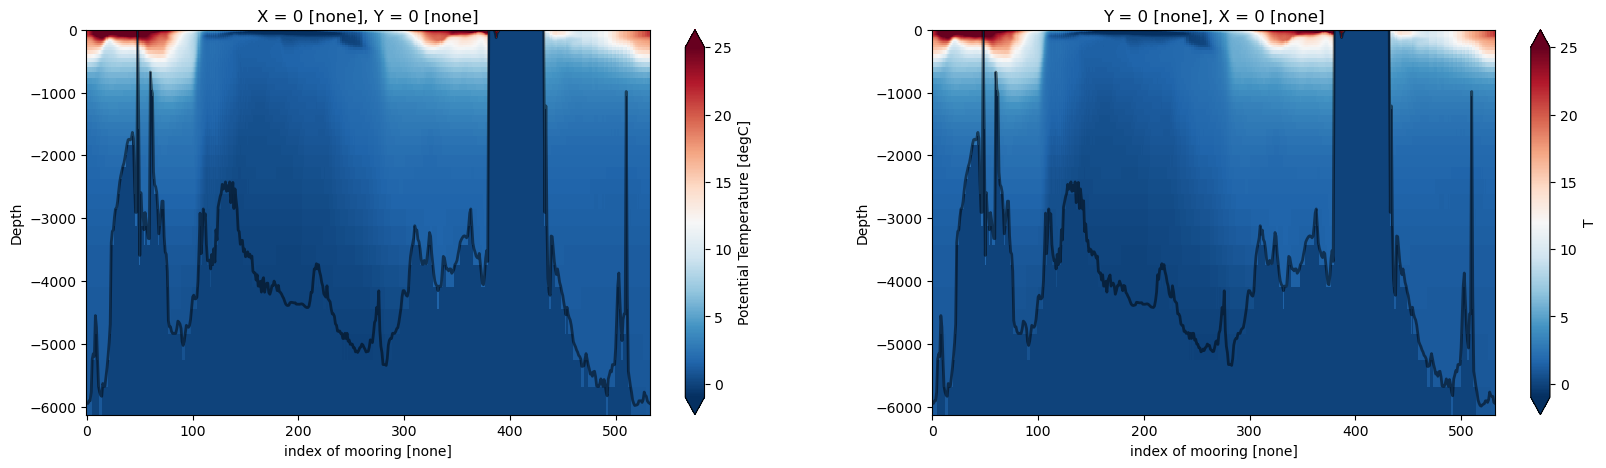

In [33]:
plt.rcParams["figure.figsize"] = [20,5]
fig, axes = plt.subplots(1, 2)
od_moor._ds['T'].squeeze().plot(ax=axes[0], cmap='RdBu_r', vmin=-1, vmax=25)
(1- od_moor._ds['Depth'].squeeze()).plot(ax=axes[0], color='k', lw=2, alpha=0.5)
od_moor_serial._ds['T'].squeeze().plot(ax=axes[1], cmap='RdBu_r', vmin=-1, vmax=25)
(1-od_moor_serial._ds['Depth'].squeeze()).plot(ax=axes[1], color='k', lw=2, alpha=0.5)
plt.show()

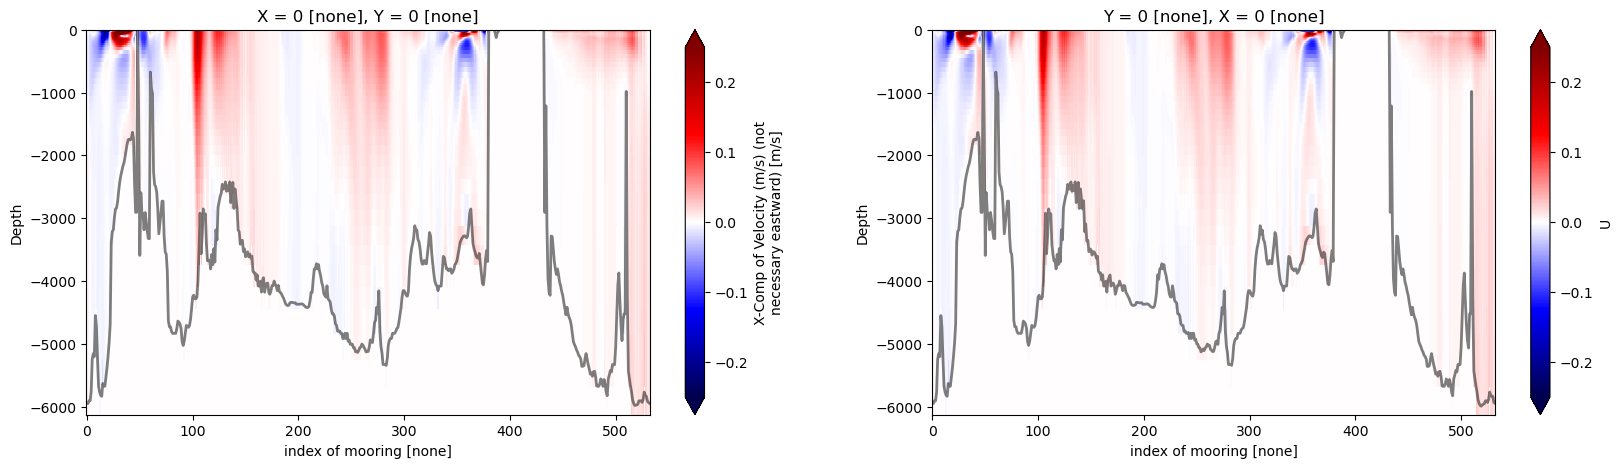

In [34]:
plt.rcParams["figure.figsize"] = [20,5]
fig, axes = plt.subplots(1, 2)
od_moor._ds['U'].isel(Xp1=0).squeeze().plot(ax=axes[0], cmap='seismic', vmin=-0.25, vmax=0.25)
(1- od_moor._ds['Depth'].squeeze()).plot(ax=axes[0], color='k', lw=2, alpha=0.5)
od_moor_serial._ds['U'].isel(Xp1=0).squeeze().plot(ax=axes[1], cmap='seismic', vmin=-0.25, vmax=0.25)
(1- od_moor_serial._ds['Depth'].squeeze()).plot(ax=axes[1], color='k', lw=2, alpha=0.5)
plt.show()

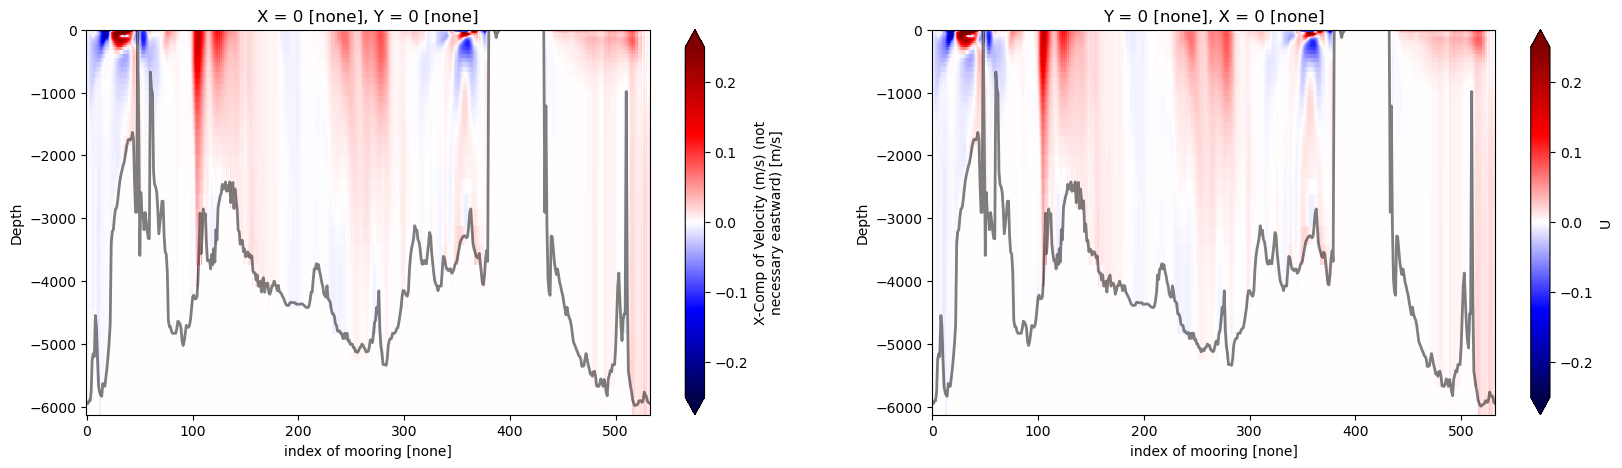

In [35]:
plt.rcParams["figure.figsize"] = [20,5]
fig, axes = plt.subplots(1, 2)
od_moor._ds['U'].isel(Xp1=1).squeeze().plot(ax=axes[0], cmap='seismic', vmin=-0.25, vmax=0.25)
(1- od_moor._ds['Depth'].squeeze()).plot(ax=axes[0], color='k', lw=2, alpha=0.5)
od_moor_serial._ds['U'].isel(Xp1=1).squeeze().plot(ax=axes[1], cmap='seismic', vmin=-0.25, vmax=0.25)
(1- od_moor_serial._ds['Depth'].squeeze()).plot(ax=axes[1], color='k', lw=2, alpha=0.5)
plt.show()

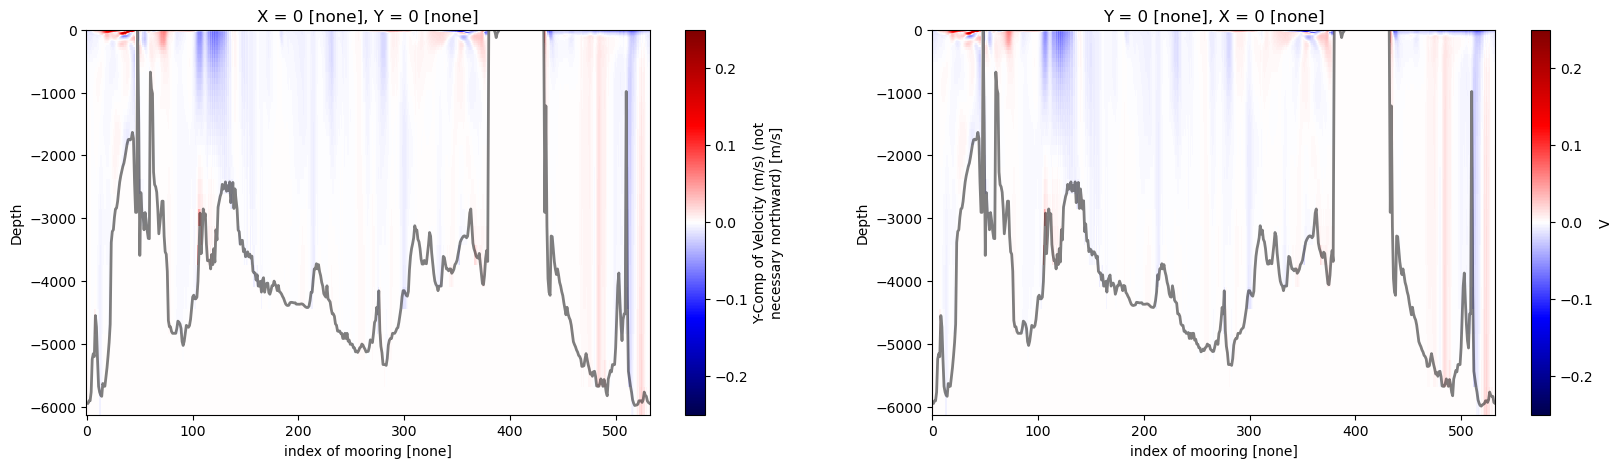

In [36]:
plt.rcParams["figure.figsize"] = [20,5]
fig, axes = plt.subplots(1, 2)
od_moor._ds['V'].isel(Yp1=0).squeeze().plot(ax=axes[0], cmap='seismic', vmin=-0.25, vmax=0.25)
(1- od_moor._ds['Depth'].squeeze()).plot(ax=axes[0], color='k', lw=2, alpha=0.5)
od_moor_serial._ds['V'].isel(Yp1=0).squeeze().plot(ax=axes[1], cmap='seismic', vmin=-0.25, vmax=0.25)
(1- od_moor_serial._ds['Depth'].squeeze()).plot(ax=axes[1], color='k', lw=2, alpha=0.5)
plt.show()

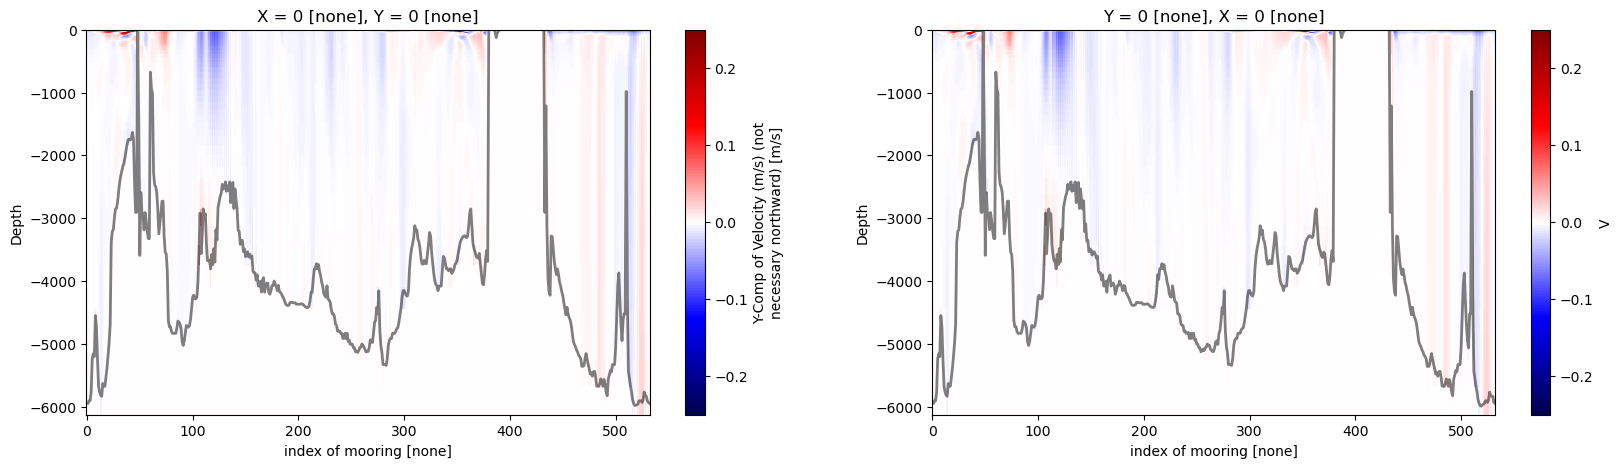

In [37]:
plt.rcParams["figure.figsize"] = [20,5]
fig, axes = plt.subplots(1, 2)
od_moor._ds['V'].isel(Yp1=1).squeeze().plot(ax=axes[0], cmap='seismic', vmin=-0.25, vmax=0.25)
(1- od_moor._ds['Depth'].squeeze()).plot(ax=axes[0], color='k', lw=2, alpha=0.5)
od_moor_serial._ds['V'].isel(Yp1=1).squeeze().plot(ax=axes[1], cmap='seismic', vmin=-0.25, vmax=0.25)
(1- od_moor_serial._ds['Depth'].squeeze()).plot(ax=axes[1], color='k', lw=2, alpha=0.5)
plt.show()

# Newly created coordinates

The coordinates `[XU, YU, XV, YV]` are computed with `OceanSpy`, and are needed to compute volume transport


## with `cutout`

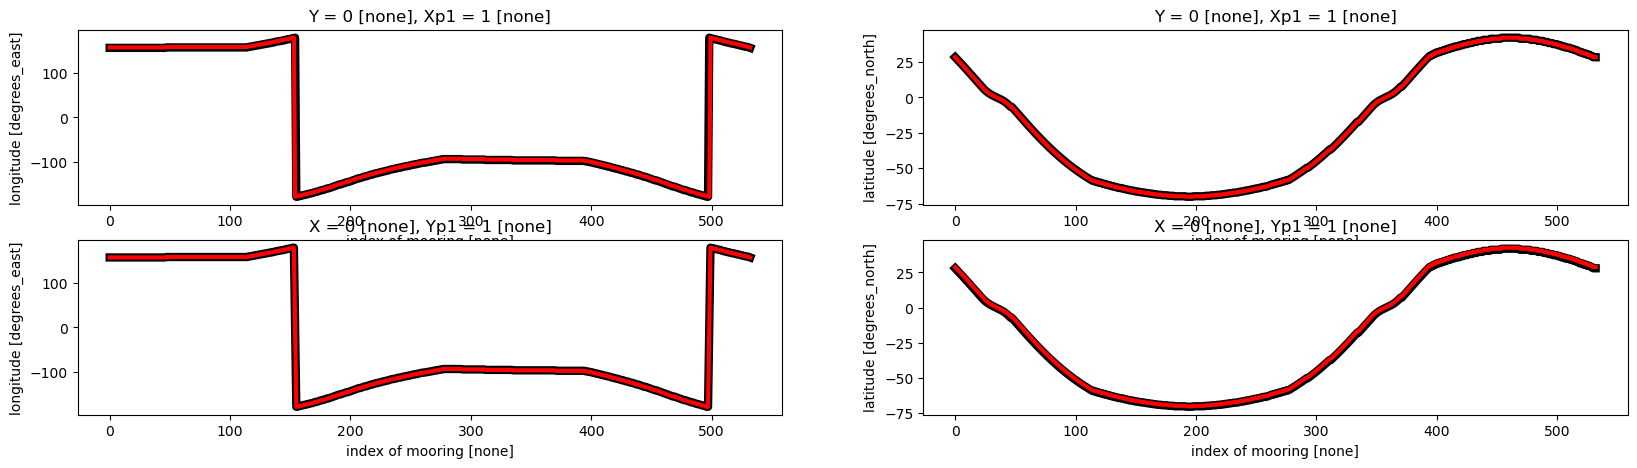

In [38]:

plt.rcParams["figure.figsize"] = [20,5]
fig, axes = plt.subplots(2, 2)

od_moor._ds['XU'].isel(Xp1=0).squeeze().plot(ax=axes[0, 0], color='k', lw=6)
od_moor._ds['XU'].isel(Xp1=1).squeeze().plot(ax=axes[0, 0], color='r', lw=3)

od_moor._ds['YU'].isel(Xp1=0).squeeze().plot(ax=axes[0, 1], color='k', lw=6)
od_moor._ds['YU'].isel(Xp1=1).squeeze().plot(ax=axes[0, 1], color='r', lw=3)

od_moor._ds['XV'].isel(Yp1=0).squeeze().plot(ax=axes[1, 0], color='k', lw=6)
od_moor._ds['XV'].isel(Yp1=1).squeeze().plot(ax=axes[1, 0], color='r', lw=3)

od_moor._ds['YV'].isel(Yp1=0).squeeze().plot(ax=axes[1, 1], color='k', lw=6)
od_moor._ds['YV'].isel(Yp1=1).squeeze().plot(ax=axes[1, 1], color='r', lw=3)


plt.show()

## without `cutout`

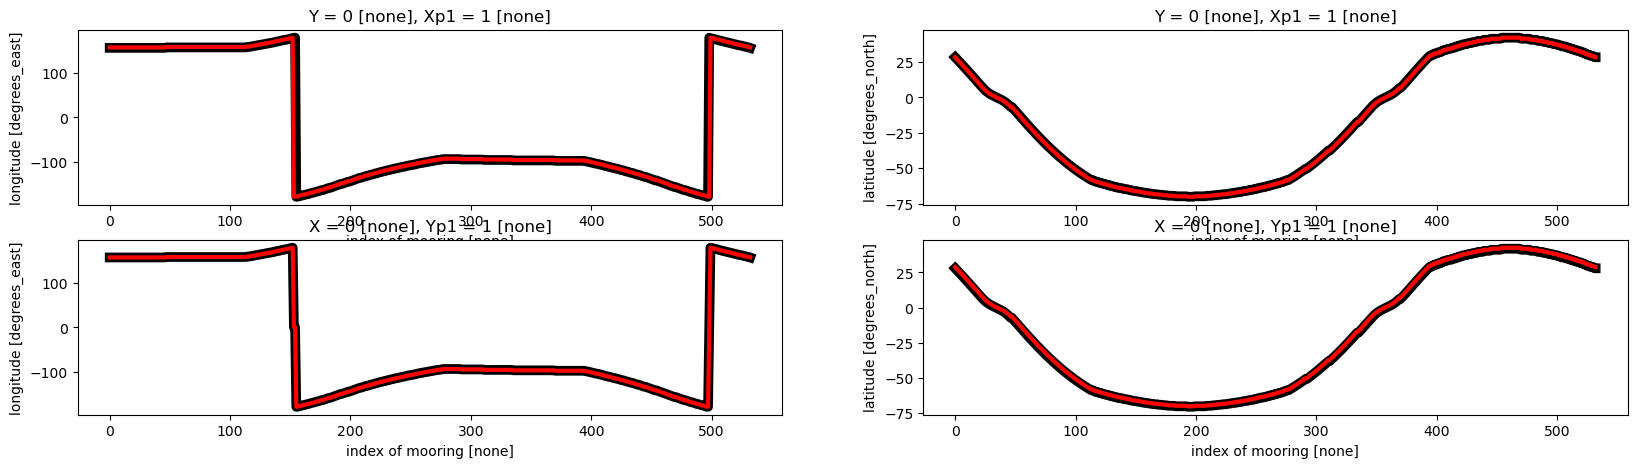

In [39]:

plt.rcParams["figure.figsize"] = [20,5]
fig, axes = plt.subplots(2, 2)

od_moor_serial._ds['XU'].isel(Xp1=0).squeeze().plot(ax=axes[0, 0], color='k', lw=7)
od_moor_serial._ds['XU'].isel(Xp1=1).squeeze().plot(ax=axes[0, 0], color='r', lw=3)

od_moor_serial._ds['YU'].isel(Xp1=0).squeeze().plot(ax=axes[0, 1], color='k', lw=7)
od_moor_serial._ds['YU'].isel(Xp1=1).squeeze().plot(ax=axes[0, 1], color='r', lw=3)

od_moor_serial._ds['XV'].isel(Yp1=0).squeeze().plot(ax=axes[1, 0], color='k', lw=7)
od_moor_serial._ds['XV'].isel(Yp1=1).squeeze().plot(ax=axes[1, 0], color='r', lw=3)

od_moor_serial._ds['YV'].isel(Yp1=0).squeeze().plot(ax=axes[1, 1], color='k', lw=7)
od_moor_serial._ds['YV'].isel(Yp1=1).squeeze().plot(ax=axes[1, 1], color='r', lw=3)


plt.show()

# Volume transport

In [40]:
%%time
ds_out = mooring_volume_transport(od_moor)

Computing horizontal volume transport.
CPU times: user 4.67 s, sys: 1.36 s, total: 6.03 s
Wall time: 3.75 s


In [41]:
%%time
ds_out_serial = mooring_volume_transport(od_moor_serial)

Computing horizontal volume transport.
CPU times: user 320 ms, sys: 14.2 ms, total: 334 ms
Wall time: 328 ms


# Visual Comparisons of transports

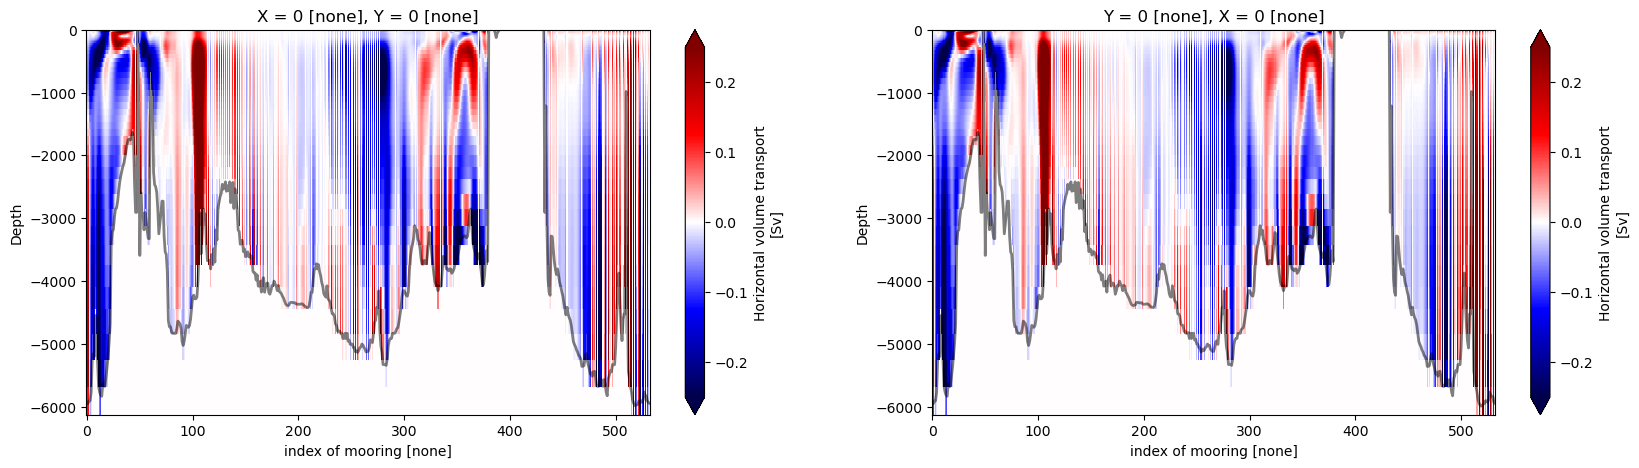

In [42]:
plt.rcParams["figure.figsize"] = [20, 5]
fig, axes = plt.subplots(1, 2)
ds_out['transport'].isel(path=0).squeeze().plot(ax=axes[0], cmap='seismic', vmin=-0.25, vmax=0.25)
(1- od_moor._ds['Depth'].squeeze()).plot(ax=axes[0], color='k', lw=2, alpha=0.5)
ds_out_serial['transport'].isel(path=0).squeeze().plot(ax=axes[1], cmap='seismic', vmin=-0.25, vmax=0.25)
(1- od_moor_serial._ds['Depth'].squeeze()).plot(ax=axes[1], color='k', lw=2, alpha=0.5)
plt.show()

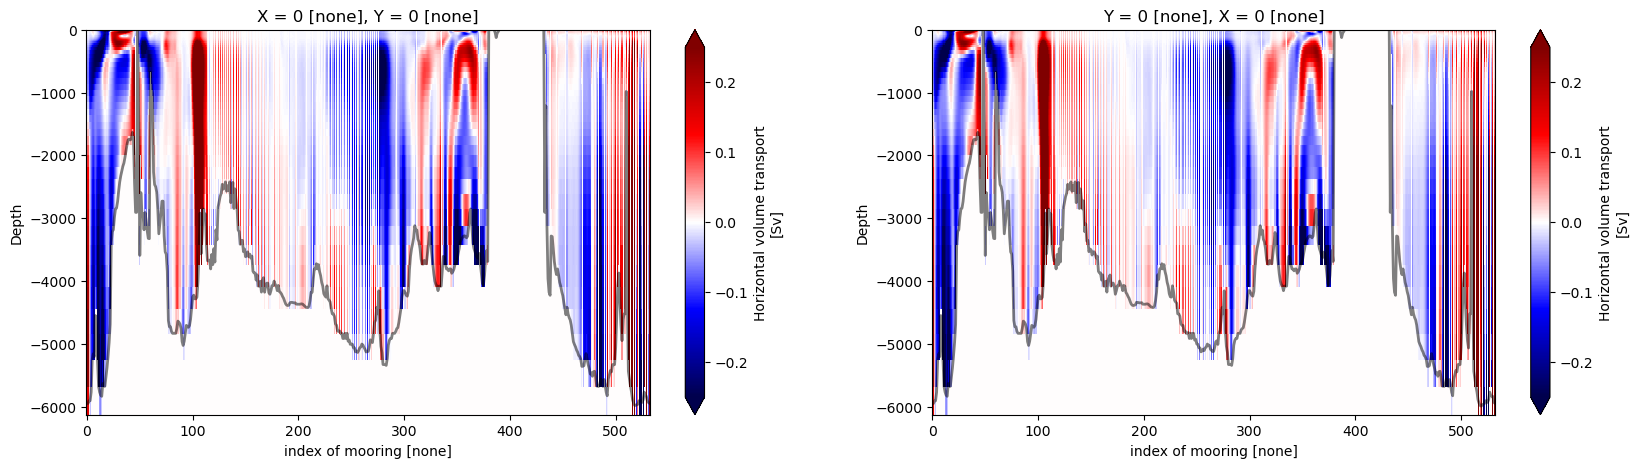

In [44]:
plt.rcParams["figure.figsize"] = [20, 5]
fig, axes = plt.subplots(1, 2)
ds_out['transport'].isel(path=1).squeeze().plot(ax=axes[0], cmap='seismic', vmin=-0.25, vmax=0.25)
(1- od_moor._ds['Depth'].squeeze()).plot(ax=axes[0], color='k', lw=2, alpha=0.5)
ds_out_serial['transport'].isel(path=1).squeeze().plot(ax=axes[1], cmap='seismic', vmin=-0.25, vmax=0.25)
(1- od_moor_serial._ds['Depth'].squeeze()).plot(ax=axes[1], color='k', lw=2, alpha=0.5)
plt.show()

In [ ]:
client.close()

In [45]:
pc = [{"type":"LineString","coordinates":[[-157.58510458895236,-49.929113472333654],[-158.3335453373931,-56.4180474136013],[-157.58510458895236,-66.9491001967596],[-127.64747465132241,-65.43909170451556],[-104.82003182387959,-66.9491001967596],[-76.75350375735152,-64.48901164230372],[-59.91358691743467,-59.9649368160756],[-49.06119606504382,-59.77709811839834],[-49.06119606504382,-67.09518612687597],[-40.82834783219558,-73.04637258315987],[-2.283649287497039,-67.38473350379634],[22.78911578526804,-66.05394012511698],[49.732982729134996,-63.504730811017126],[78.9221719183242,-62.311936937237796],[102.52851624436076,-61.26497563498257],[119.36843308427763,-59.222724692731425],[120.1168738327184,-52.52506277528884],[114.50356821941274,-45.9407502581646],[90.55346426930878,-41.340346963740906],[57.99629171213625,-37.88205039129804],[30.303984019828572,-37.5860952909328],[-17.222003506158956,-35.481526087073114],[-41.17210745626293,-43.549163986078796],[-53.147159431314876,-52.978067922480726],[-61.7542280383835,-56.43483466663744],[-70.73551701967247,-57.85575305946762],[-87.20121348536895,-51.371854559255056],[-81.21368749784294,-39.92040864793066],[-84.20745049160595,-22.77515385083268],[-106.6606729448284,1.2986691385364821],[-131.35921764337309,21.715726006363894],[-154.5608808450363,20.669007174659797],[-157.92886421301966,-8.400687880491319],[-169.90391618807166,-25.50672614934794],[-167.28437356852905,-39.05399570881964],[-157.55464383879928,-42.454492348945855],[-157.55464383879928,-50.427847608420734]]}]
lonsC, latsC = ospy.utils.viewer_to_range(pc)

extracting LineString


In [46]:
args = {
    'Xmoor': lonsC,
    'Ymoor': latsC,
}

In [47]:
%%time
od_moor = od.subsample.mooring_array(**args, serial=True)

Extracting mooring array
CPU times: user 2.12 s, sys: 64.2 ms, total: 2.18 s
Wall time: 2.15 s


In [48]:
XC, YC = od_moor._ds['XC'].squeeze().values, od_moor._ds['YC'].squeeze().values

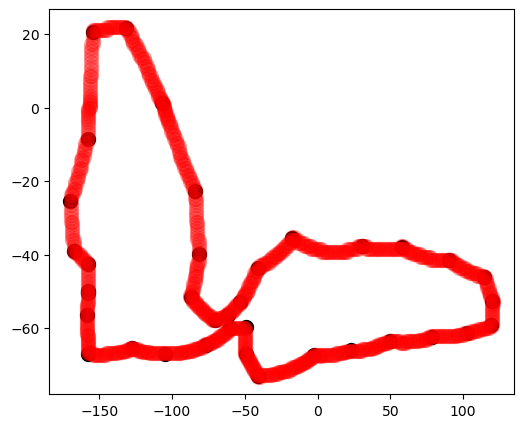

In [49]:
fig = plt.figure(figsize=(6, 5), facecolor='w')
plt.plot(lonsC, latsC,'k', ls='', lw=2, marker='o', markersize=10)
plt.plot(XC, YC, 'r',ls='', marker='o', markersize=10, alpha=0.25)
# plt.xlim(0, 90)
plt.show()

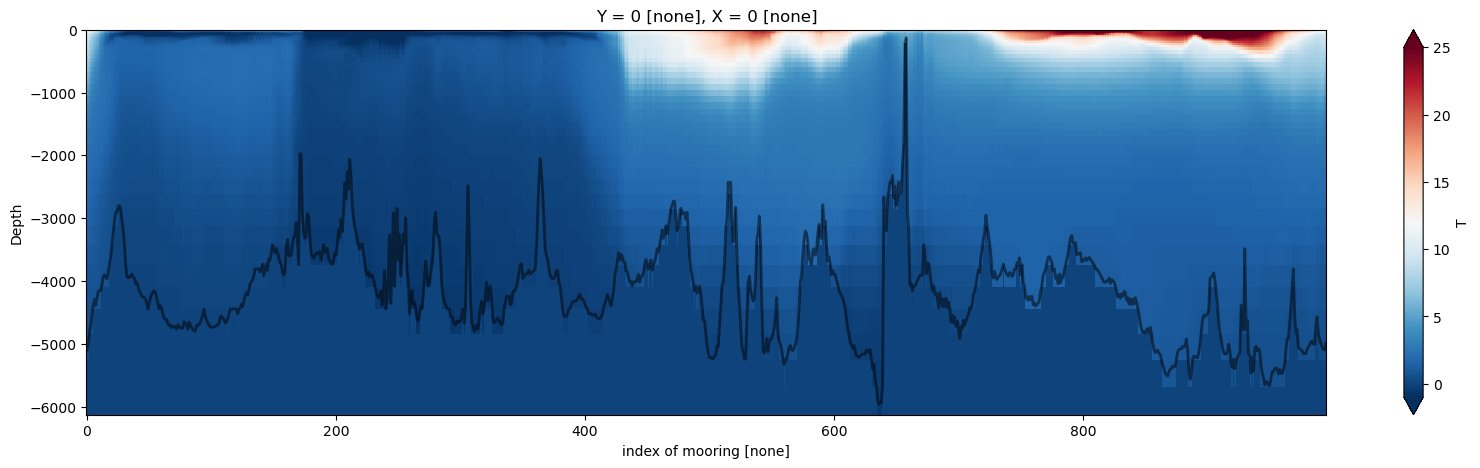

In [50]:
od_moor._ds['T'].squeeze().plot(cmap='RdBu_r', vmin=-1, vmax=25)
(1- od_moor._ds['Depth'].squeeze()).plot(color='k', lw=2, alpha=0.5)
plt.show()

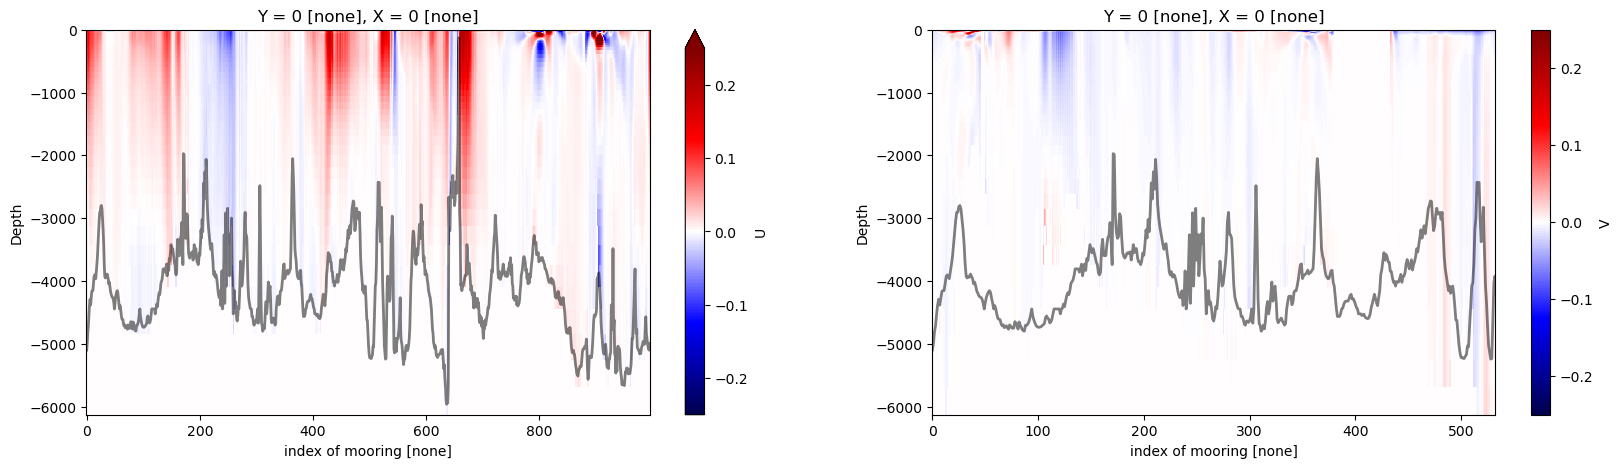

In [52]:
plt.rcParams["figure.figsize"] = [20,5]
fig, axes = plt.subplots(1, 2)
od_moor._ds['U'].isel(Xp1=0).squeeze().plot(ax=axes[0], cmap='seismic', vmin=-0.25, vmax=0.25)
(1- od_moor._ds['Depth'].squeeze()).plot(ax=axes[0], color='k', lw=2, alpha=0.5)
od_moor_serial._ds['V'].isel(Yp1=0).squeeze().plot(ax=axes[1], cmap='seismic', vmin=-0.25, vmax=0.25)
(1- od_moor._ds['Depth'].squeeze()).plot(ax=axes[1], color='k', lw=2, alpha=0.5)
plt.show()

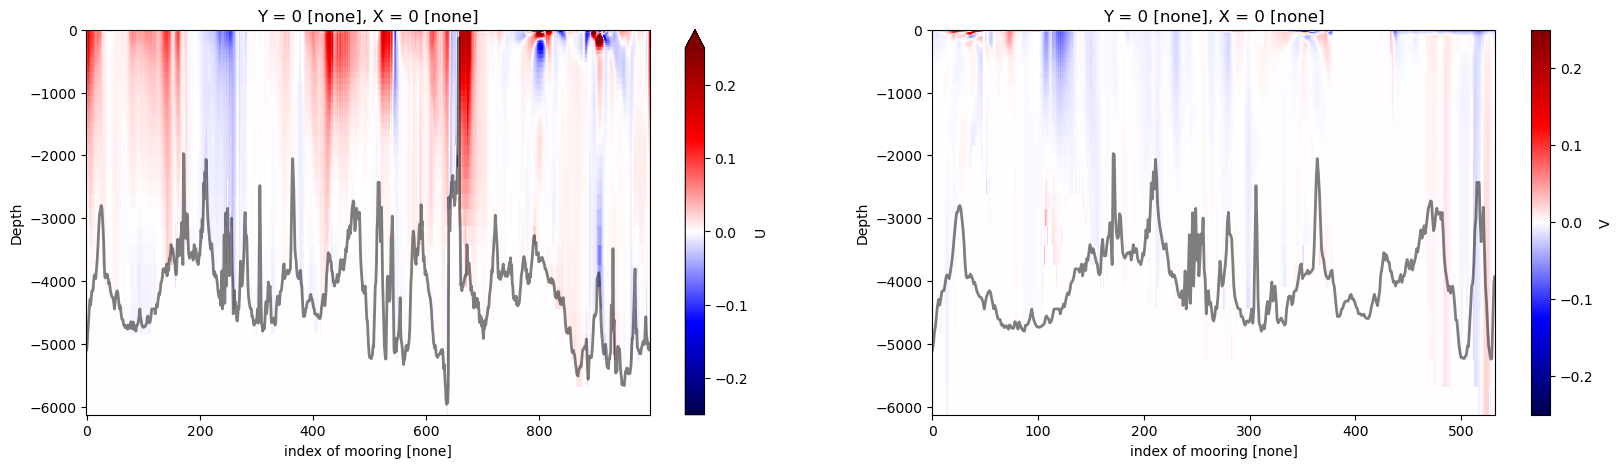

In [53]:
plt.rcParams["figure.figsize"] = [20,5]
fig, axes = plt.subplots(1, 2)
od_moor._ds['U'].isel(Xp1=1).squeeze().plot(ax=axes[0], cmap='seismic', vmin=-0.25, vmax=0.25)
(1- od_moor._ds['Depth'].squeeze()).plot(ax=axes[0], color='k', lw=2, alpha=0.5)
od_moor_serial._ds['V'].isel(Yp1=1).squeeze().plot(ax=axes[1], cmap='seismic', vmin=-0.25, vmax=0.25)
(1- od_moor._ds['Depth'].squeeze()).plot(ax=axes[1], color='k', lw=2, alpha=0.5)
plt.show()

In [54]:
%%time
ds_out = mooring_volume_transport(od_moor)

Computing horizontal volume transport.
CPU times: user 632 ms, sys: 12.4 ms, total: 644 ms
Wall time: 640 ms


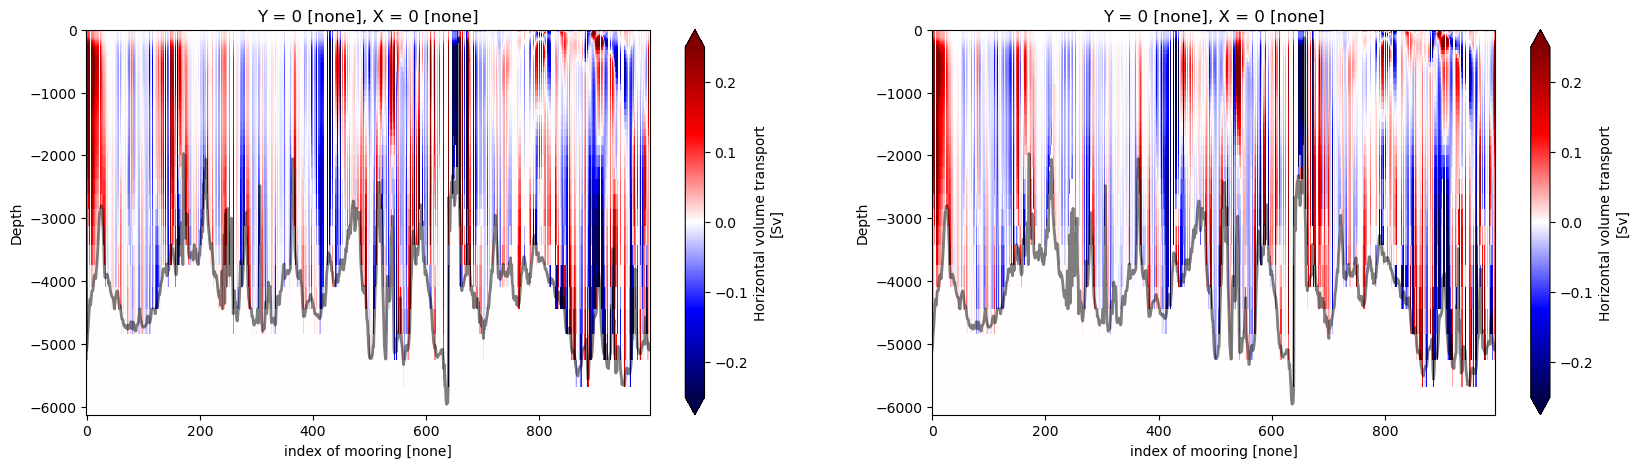

In [55]:
plt.rcParams["figure.figsize"] = [20, 5]
fig, axes = plt.subplots(1, 2)
ds_out['transport'].isel(path=0).squeeze().plot(ax=axes[0], cmap='seismic', vmin=-0.25, vmax=0.25)
(1- od_moor._ds['Depth'].squeeze()).plot(ax=axes[0], color='k', lw=2, alpha=0.5)
ds_out['transport'].isel(path=1).squeeze().plot(ax=axes[1], cmap='seismic', vmin=-0.25, vmax=0.25)
(1- od_moor._ds['Depth'].squeeze()).plot(ax=axes[1],color='k', lw=2, alpha=0.5)
plt.show()